# Setting the environment

In [1]:
import platform

print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import numpy as np
print(f"Numpy version: {np.__version__}")

import matplotlib
print(f"Matplotlib version: {matplotlib.__version__}")
import matplotlib.pyplot as plt
import seaborn as sns

import torch
print(f"PyTorch version: {torch.__version__}")
import torch.nn as nn
from torchvision.utils import save_image
from torchvision.datasets import MNIST
from torchvision.transforms.transforms import Compose, Normalize, ToTensor, Resize
from torch.utils.data import DataLoader

# from torch.utils.tensorboard import SummaryWriter

Python version: 3.8.9
Numpy version: 1.21.5
Matplotlib version: 3.5.1
PyTorch version: 1.10.1


In [2]:

%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 8
%config InlineBackend.figure_format = 'retina'
sns.set()
%load_ext tensorboard

# Loading the MNIST dataset

In [18]:
!rm -rf "./data"
!mkdir output

In [19]:
workers = 0

In [43]:
def get_data_loader():
    mnist_data = MNIST(
        root='./data',
        download=True,
        transform=Compose([
            Resize(64),
            ToTensor(),
            Normalize((0.5,), (0.5,))])
    )

    return DataLoader(
        mnist_data,
        batch_size=64,
        shuffle=True,
        num_workers=workers,
    ), mnist_data

In [44]:
data_loader, dataset = get_data_loader()

print("Dataset size : ", len(data_loader))

Dataset size :  938


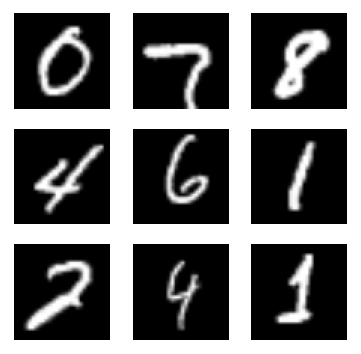

In [48]:
figure = plt.figure(figsize=(3, 3))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data_loader), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)

    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Building and training the models

In [22]:
# custom weights initialization called on generator and discriminator
def initialize_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [23]:
nb_gpu = 1
ngf = 64
ndf = 64
z = 100
n_channels = 1
device = torch.device('cuda:0' if (torch.cuda.is_available() and nb_gpu > 0) else 'cpu')

In [30]:
# noinspection PyTypeChecker

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.nb_gpu = nb_gpu
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(z, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, n_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        if x.is_cuda and self.nb_gpu > 1:
             return nn.parallel.data_parallel(self.generator, x, range(self.nb_gpu))
        return self.generator(x)

In [31]:
# noinspection PyTypeChecker

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.nb_gpu = nb_gpu
        self.discriminator = nn.Sequential(
            nn.Conv2d(n_channels, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        if x.is_cuda and self.nb_gpu > 1:
            return nn.parallel.data_parallel(self.discriminator, x, range(self.nb_gpu)).view(-1, 1).squeeze(1)
        return self.discriminator(x).view(-1, 1).squeeze(1)

In [49]:
generator = Generator().to(device).apply(initialize_weights)
discriminator = Discriminator().to(device).apply(initialize_weights)

# print(generator)
# print(discriminator)

In [34]:
learning_rate = 0.0002
beta_1 = 0.5
beta_2 = 0.999
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta_1, beta_2))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta_1, beta_2))

batch_size = 32
epochs = 1

criterion = nn.BCELoss()
fixed_noise = torch.randn(batch_size, z, 1, 1, device=device)

real_label = 1
fake_label = 0

In [ ]:
for epoch in range(epochs):
    for i, data in enumerate(data_loader, 0):
        ############################
        # Update Discriminator network: maximize log(Discriminator(x)) + log(1 - Discriminator(Generator(z)))
        ###########################
        # train with real
        discriminator.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label,
                           dtype=real_cpu.dtype, device=device)

        output = discriminator(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, z, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        discriminator_error = errD_real + errD_fake
        discriminator_optimizer.step()

        ############################
        # Update Generator network: maximize log(Discriminator(Generator(z)))
        ###########################
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = discriminator(fake)
        generator_error = criterion(output, label)
        generator_error.backward()
        D_G_z2 = output.mean().item()
        generator_optimizer.step()

        print('[%d/%d][%d/%d] Discriminator loss: %.4f Generator loss: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, epochs, i, len(data_loader),
                 discriminator_error.item(), generator_error.item(), D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            save_image(real_cpu,
                    "output/real_samples.png",
                    normalize=True)
            fake = generator(fixed_noise)
            save_image(fake.detach(),
                    "output/fake_samples_epoch_%03d.png",
                    normalize=True)
    # do checkpointing
    torch.save(generator.state_dict(), f"output/generator_epoch_{epoch}.pth")
    torch.save(discriminator.state_dict(), f"output/discriminator_epoch_{epoch}.pth")